<a href="https://colab.research.google.com/github/alessandromartignano/Autoencoders/blob/master/Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Autoencoders

---

In this notebook we will showcase the use of autoencoders for denoising waveforms signals, hopefully improving the Signal-To-Noise Ratio (SNR).

An autoencoder is a particular type of neural network which is trained to present as output a recostruction of the input but it is forced to do so by learning an encoding of it.

The network is forced to perform an efficient dimensionality reduction (very similarly to Principal Component Analysis but in a non-linear manner) of the input data, thus ignoring the "noise", by reducing the number of the node in the middle layer.

The learning process is performed in a unsupervised manner or, more accurately, self-supervised, as the expected output could be generated by simply adding noise to the input

# Input data

First we are going to generate a training set composed of random waveforms.
The waveform we are going to generate are a composition of two sine waves of random amplitude and frequency.

A noisy version of the waveforms is then generated by simply adding some gaussian noise.

The target of the network is to minimize the Signal-To-Noise Ratio (SNR) of the input signals, which is so defined:

$SNR=10\: log_{10}\: \frac{ \: RMS_{signal} \: }{ \: RMS_{noise}\: } \: dB$

Where RMS is the root mean square value of the waveform:

$RMS_{signal} = \sqrt{\sum_{i=1}^{n}y_{i}^{2}}$

Some examples of the training set are plotted below.

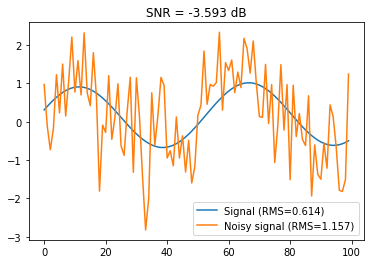

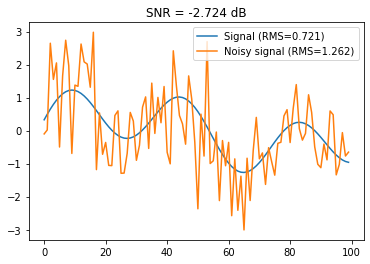

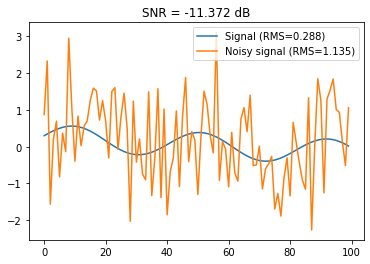

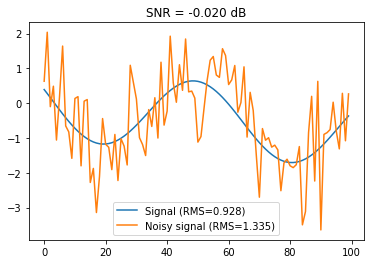

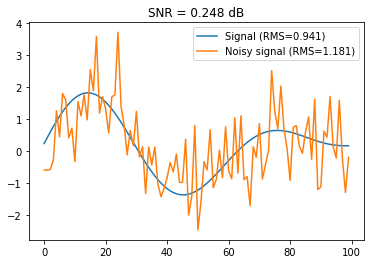

In [103]:
%matplotlib inline
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

SIGNAL_LENGHT = 100
BATCH_SIZE = 10000
NOISE_FACTOR = 10

def genSinusoid(amplitude, frequency, offset, length):
    return amplitude * np.sin(np.linspace(
        length / 15.0 * frequency * 0.0 * math.pi + offset,
        length / 15.0 * frequency * 3.0 * math.pi + offset,
        length ) / ( length / 5 )
    )

def genRndSinusoid(length):
    rndOffset = random.random() * 2 * math.pi
    rndFreq = (random.random() - 0.5) / 1.5 * 15 + 0.5
    rndAmp = random.random() + 0.1
    sinusoid = genSinusoid(rndAmp, rndFreq, rndOffset, length)
    rndOffset = random.random() * 2 * math.pi
    rndFreq = (random.random() - 0.5) / 1.5 * 15 + 0.5
    rndAmp = random.random() * 1.2
    return sinusoid + genSinusoid(rndAmp, rndFreq, rndOffset, length)

def genNoise(sinusoid, noiseAmount=1):
    return sinusoid + np.random.normal(scale=noiseAmount/10, size=sinusoid.shape[0])

def computeRMS(signal):
    return np.sqrt(np.mean(signal**2))

def computeSNR(signal, noise):
    return 10*math.log10((computeRMS(signal)/computeRMS(noise))**2)

def genSinusoidBatch(lenght, batchSize, noiseAmount=1):
    sins = []
    noisySins = []
    for _ in range(batchSize):
        sin = genRndSinusoid(lenght)
        sins.append(sin)
        noisySins.append(genNoise(sin, noiseAmount))
    return np.array([sins, noisySins])

sins, noisySins = genSinusoidBatch(SIGNAL_LENGHT, BATCH_SIZE, NOISE_FACTOR)

for x in range(5):
    s = sins[x]
    ns = noisySins[x]
    plt.figure()
    plt.plot(s, label='Signal (RMS=%.3f)'%computeRMS(s))
    plt.plot(ns, label='Noisy signal (RMS=%.3f)'%computeRMS(ns))
    plt.legend()
    plt.title('SNR = %.3f dB' % computeSNR(s, ns-s))

# Network layout

We then proceed to construct the network.

For convenience, input data are sequences of a fixed number of samplings of a waveform. Longer waveform could be splitted into chunks before being submitted to the network.

The input layer and the output layer must thus have the same number of neurons, corresponding to the number of samplings in the training set waveforms.

The hidden layer, conversely, must be composed of very few neurons for the network to correctly learn an efficient encoding of meaningful features of the input data, and not merely copy it.

The Mean Square Error (MSE) is chosen as loss function for the network.

MSE is the sum of the squared differences between the prediction ($\hat{y}$) and the expected ($y$). We aim to minimizze MSE.

$ {MSE} = \frac{1}{n} \sum_{i=1}^n \left(\hat{y}_i - y_i\right)^2 $

As for the backpropagation algorithm, ADAM is empirically chosen over more classical methods like Stochastic Gradient Descent.

An early stoppping strategy is also adopted based on the values of the loss function.

In [104]:
model = Sequential()
model.add(Dense(12, input_dim=SIGNAL_LENGHT, activation='relu'))
model.add(Dense(SIGNAL_LENGHT))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=5, 
        verbose=1, mode='auto', restore_best_weights=True)
model.fit(noisySins,sins,callbacks=[monitor],verbose=1,epochs=50)


Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 12)                1212      
_________________________________________________________________
dense_49 (Dense)             (None, 100)               1300      
Total params: 2,512
Trainable params: 2,512
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
313/313 [==============================] - 0s 1ms/step - loss: 0.3425
Epoch 2/50
313/313 [==============================] - 0s 1ms/step - loss: 0.1060
Epoch 3/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0691
Epoch 4/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0581
Epoch 5/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0537
Epoch 6/50
313/313 [==============================] - 0s 1ms/step - loss: 0.0519
Epoch 7/50
313/313 [=======

# Results

For evaluating the results, a new test set of waveforms is randomly generated.
Noisy signals are submitted to the network and their SNR is compared with the output SNR.

Both input and output signals' SNR are computed wrt. the original signal, without noise.

An average of the gain (i.e. increment in SNR) is computed across the batch of waveforms.

A sample of the output data is presented below, compared with the original signals.

Average SNR improvement: 13.717 dB


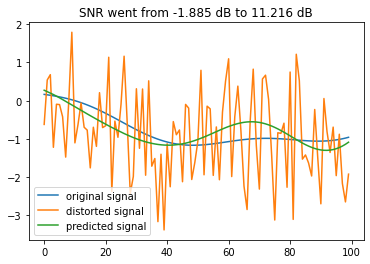

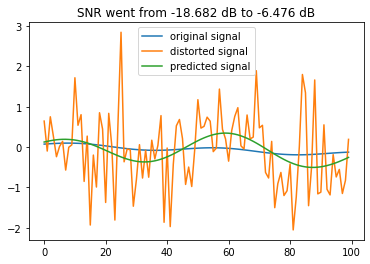

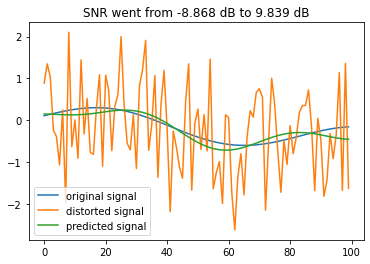

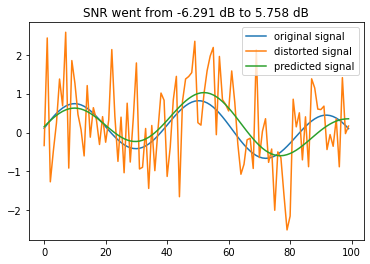

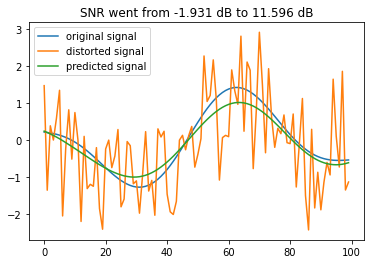

In [105]:
testSet = genSinusoidBatch(SIGNAL_LENGHT, BATCH_SIZE, NOISE_FACTOR)
sins = testSet[0]
noisySins = testSet[1]
predictions = model.predict(noisySins)

def previewResults(sins, noisySins, predictions, n):
  for _ in range(n):
    x = random.randrange(sins.shape[0])
    s = sins[x]
    ns = noisySins[x]
    p = predictions[x]
    plt.figure()
    plt.plot(sins[x], label='original signal')
    plt.plot(noisySins[x], label='distorted signal')
    plt.plot(predictions[x], label='predicted signal')
    plt.legend()
    initSNR = computeSNR(s, ns-s)
    SNR = computeSNR(s, p-s)
    plt.title('SNR went from %.3f dB to %.3f dB' % (initSNR, SNR))

def computeImprovement(sins, noisySins, predictions, batchSize = BATCH_SIZE):
  improvedSNRs = []
  for x in range(batchSize):
    s = sins[x]
    ns = noisySins[x]
    p = predictions[x]
    initSNR = computeSNR(s, ns-s)
    SNR = computeSNR(s, p-s)
    improvedSNRs.append(SNR-initSNR)
  return np.average(np.array(improvedSNRs))

print("Average SNR improvement: %.3f dB" % computeImprovement(sins, noisySins, predictions))
previewResults(sins, noisySins, predictions, 5)

# Testing with real data

We now proceed to retrain and test our network against a real dataset.

The dataset is a subset of DEEPSIG RADIOML 2018.01A available here:

https://www.deepsig.ai/datasets


In [106]:
!wget https://github.com/alessandromartignano/RADIOML-2018.01A-SNR30/raw/master/DEEPSIG_2018_SNR30.hdf5.tar.gz
!tar zxvf DEEPSIG_2018_SNR30.hdf5.tar.gz

--2020-06-06 17:48:10--  https://github.com/alessandromartignano/RADIOML-2018.01A-SNR30/raw/master/DEEPSIG_2018_SNR30.hdf5.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alessandromartignano/RADIOML-2018.01A-SNR30/master/DEEPSIG_2018_SNR30.hdf5.tar.gz [following]
--2020-06-06 17:48:10--  https://raw.githubusercontent.com/alessandromartignano/RADIOML-2018.01A-SNR30/master/DEEPSIG_2018_SNR30.hdf5.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92655867 (88M) [application/octet-stream]
Saving to: ‘DEEPSIG_2018_SNR30.hdf5.tar.gz.1’

DEEPSIG_2018_SNR30. 100%[===================>]  88.36M  7

In [107]:
from sklearn.model_selection import train_test_split
import h5py 

with h5py.File("DEEPSIG_2018_SNR30.hdf5", "r") as f:
  data = f['dataset'][:]

train_set ,test_set = train_test_split(data,test_size=0.3)

def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def decompose(set):
  signals = []
  noisySignals = []
  for x in set:
    for chunk in list(chunks(x, 100))[:10]:
      noisySignals.append(genNoise(chunk, NOISE_FACTOR))
      signals.append(chunk)
  return (np.array(signals), np.array(noisySignals))

signals, noisySignals = decompose(train_set)
model.fit(noisySignals,signals,callbacks=[monitor],verbose=1,epochs=50)


Epoch 1/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1919
Epoch 2/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1422
Epoch 3/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1318
Epoch 4/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1311
Epoch 5/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1306
Epoch 6/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1303
Epoch 7/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1300
Epoch 8/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1296
Epoch 9/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1298
Epoch 10/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1295
Epoch 11/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1292
Epoch 12/50
5376/5376 [==============================] - 7s 1ms/step - loss: 0.1293
E

Average SNR improvement: 9.362 dB


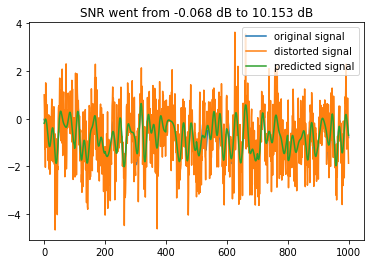

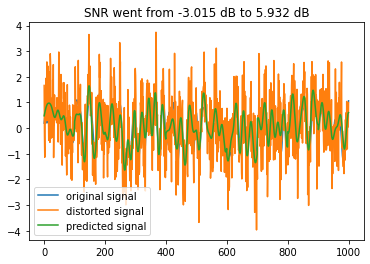

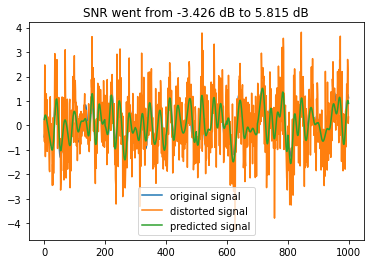

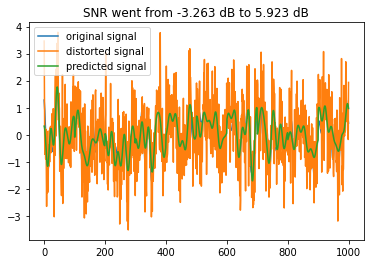

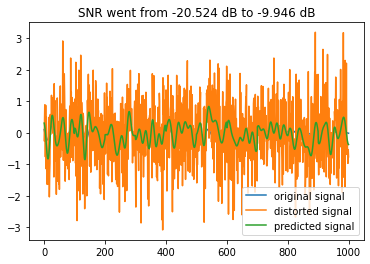

In [108]:
signals, noisySignals = decompose(test_set)
predictions = model2.predict(noisySignals)

def recompose(signals):
  return signals.reshape((signals.shape[0]//10, 1000))

signals = recompose(signals)
noisySignals = recompose(noisySignals)
predictions = recompose(predictions)

print("Average SNR improvement: %.3f dB" % computeImprovement(signals, noisySignals, predictions, signals.shape[0]))
previewResults(signals, noisySignals, predictions, 5)